<a href="https://colab.research.google.com/github/ju-ki/atma10/blob/master/exp6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!git clone https://github.com/facebookresearch/fastText.git
!pip install fastText xfeat category_encoders texthero  umap transformers MulticoreTSNE
!rm -rf fastText

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.22 MiB | 24.06 MiB/s, done.
Resolving deltas: 100% (2417/2417), done.


In [58]:
import os 
import glob 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import texthero as hero
from fasttext import load_model
from tqdm import tqdm
tqdm.pandas()

sns.set()
CODE_PATH = "/content/drive/MyDrive/atmacup10/code/"
INPUT_PATH = "/content/drive/MyDrive/atmacup10/data/raw/"
OUTPUT_PAHT = "/content/drive/MyDrive/atmacup10/data/submission/"

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [71]:
import inspect

def param_to_name(params: dict, key_sep='_', key_value_sep='=') -> str:
    """
    dict を `key=value` で連結した string に変換します.
    Args:
        params:
        key_sep:
            key 同士を連結する際に使う文字列.
        key_value_sep:
            それぞれの key / value を連結するのに使う文字列.
            `"="` が指定されると例えば { 'foo': 10 } は `"foo=10"` に変換されます.
    Returns:
        文字列化した dict
    """
    sorted_params = sorted(params.items())
    return key_sep.join(map(lambda x: key_value_sep.join(map(str, x)), sorted_params))


def cachable(function):
    attr_name = '__cachefile__'
    def wrapper(*args, **kwrgs):
        force = kwrgs.pop('force', False)
        call_args = inspect.getcallargs(function, *args, **kwrgs)

        arg_name = param_to_name(call_args)
        name = attr_name + arg_name

        use_cache = hasattr(function, name) and not force

        if use_cache:
            cache_object = getattr(function, name)
        else:
            print('run')
            cache_object = function(*args, **kwrgs)
            setattr(function, name, cache_object)

        return cache_object

    return wrapper

@cachable
def read_csv(name):

    if '.csv' not in name:
        name = name + '.csv'

    return pd.read_csv(os.path.join(INPUT_PATH, name))

def whole_df():
  return pd.concat([read_csv("train"), read_csv("test")], ignore_index=True).reset_index

train_df = read_csv("train")
test_df = read_csv("test")

run
run


In [72]:
principal_maker_df = read_csv("principal_maker")
occupation_df = read_csv("principal_maker_occupation")
maker = read_csv("maker")

run
run
run


In [73]:
occupation_df = occupation_df.groupby("id")["name"].apply(list)

In [74]:
principal_maker_df = pd.merge(principal_maker_df, occupation_df, on="id", how="left")

In [75]:
display(principal_maker_df[principal_maker_df["object_id"] == "8e29d23e6dd057bf1ecb"])
display(principal_maker_df[principal_maker_df["object_id"] == "5db27900fc270f24576e"])
display(principal_maker_df[principal_maker_df["object_id"] == "aae732e62bf3ef71fce6"])

,id,object_id,qualification,roles,productionPlaces,maker_name,name
13667,13668,8e29d23e6dd057bf1ecb,mentioned on object,print maker,NaN,Jean Joseph Baléchou,[print maker]
13668,13669,8e29d23e6dd057bf1ecb,mentioned on object,NaN,NaN,Juste Aurèle Meissonnier,"[print maker, draughtsman]"


,id,object_id,qualification,roles,productionPlaces,maker_name,name
8967,8968,5db27900fc270f24576e,NaN,NaN,Antwerp,anonymous,NaN
8968,8969,5db27900fc270f24576e,mentioned on object,publisher,Antwerp,G. Zazzarini et Cie.,[publisher]


,id,object_id,qualification,roles,productionPlaces,maker_name,name
16411,16412,aae732e62bf3ef71fce6,attributed to,NaN,NaN,anoniem (Monumentenzorg),NaN
16412,16413,aae732e62bf3ef71fce6,possibly,NaN,NaN,A.J.M. Mulder,NaN


In [76]:
train_df = pd.merge(train_df, maker, left_on="principal_maker", right_on="name", how="left")
test_df = pd.merge(test_df, maker, left_on="principal_maker", right_on="name", how="left")

In [77]:
train_df["acquisition_date"] = pd.to_datetime(train_df["acquisition_date"])
train_df["acquisition_date"] = train_df['acquisition_date'].dt.strftime("%Y")

test_df["acquisition_date"] = pd.to_datetime(test_df["acquisition_date"])
test_df["acquisition_date"] = test_df['acquisition_date'].dt.strftime("%Y")

In [78]:
train_df["date_of_birth"] = train_df["date_of_birth"].str[:4]
train_df["date_of_death"] = train_df["date_of_death"].str[:4]
train_df["date_of_birth"] = train_df["date_of_birth"].astype(float)
train_df["date_of_death"] = train_df["date_of_death"].astype(float)


test_df["date_of_birth"] = test_df["date_of_birth"].str[:4]
test_df["date_of_death"] = test_df["date_of_death"].str[:4]
test_df["date_of_birth"] = test_df["date_of_birth"].astype(float)
test_df["date_of_death"] = test_df["date_of_death"].astype(float)

In [79]:
train_df["age"] = train_df["date_of_death"].astype(float) - train_df["date_of_birth"].astype(float)
train_df["age"] = train_df["age"].fillna("NaN")
train_df["age"] = train_df["age"].astype(float)

test_df["age"] = test_df["date_of_death"].astype(float) - test_df["date_of_birth"].astype(float)
test_df["age"] = test_df["age"].fillna("NaN")
test_df["age"] = test_df["age"].astype(float)

In [80]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12026 entries, 0 to 12025
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   object_id                 12026 non-null  object 
 1   art_series_id             12026 non-null  object 
 2   title                     12026 non-null  object 
 3   description               8506 non-null   object 
 4   long_title                12026 non-null  object 
 5   principal_maker           12026 non-null  object 
 6   principal_or_first_maker  12025 non-null  object 
 7   sub_title                 11992 non-null  object 
 8   copyright_holder          713 non-null    object 
 9   more_title                11891 non-null  object 
 10  acquisition_method        11830 non-null  object 
 11  acquisition_date          11009 non-null  object 
 12  acquisition_credit_line   3525 non-null   object 
 13  dating_presenting_date    12016 non-null  object 
 14  dating

In [81]:
train_df.loc[(train_df["age"] < 0.0) | (train_df["age"] > 100.0), "date_of_birth"] = "NaN"
train_df.loc[(train_df["age"] < 0.0) | (train_df["age"] > 100.0), "date_of_death"] = "NaN"
train_df.loc[(train_df["age"] < 0.0) | (train_df["age"] > 100.0), "age"] = "NaN"

test_df.loc[(test_df["age"] < 0.0) | (test_df["age"] > 100.0), "date_of_birth"] = "NaN"
test_df.loc[(test_df["age"] < 0.0) | (test_df["age"] > 100.0), "date_of_death"] = "NaN"
test_df.loc[(test_df["age"] < 0.0) | (test_df["age"] > 100.0), "age"] = "NaN"

train_df["age"] = train_df["age"].astype(float)
test_df["age"] = test_df["age"].astype(float)

train_df["date_of_birth"] = train_df["date_of_birth"].astype(float)
train_df["date_of_death"] = train_df["date_of_death"].astype(float)

test_df["date_of_birth"] = test_df["date_of_birth"].astype(float)
test_df["date_of_death"] = test_df["date_of_death"].astype(float)

In [82]:
#制作期間が長いほど名作なのでは
train_df["period_of_production"] = train_df["dating_year_late"].astype(float) - train_df["dating_year_early"].astype(float)
train_df["period_of_production"] = train_df["period_of_production"].fillna("NaN").astype(float)

#ここの期間が短い（遺作）は評価が高いのでは
train_df["period_between_death_year_and_late_year"] = train_df["date_of_death"].astype(float) - train_df["dating_year_late"].astype(float)
train_df["period_between_death_year_and_late_year"] = train_df["period_between_death_year_and_late_year"].fillna("NaN").astype(float)
#回収されるまでの期間が長ければ名作なのでは
train_df["period_between_acquistion_date_and_date_death"] = train_df["acquisition_date"].astype(float) - train_df["date_of_birth"].astype(float)
train_df["period_between_acquistion_date_and_date_death"] = train_df["period_between_acquistion_date_and_date_death"].fillna("NaN").astype(float)
#幼少期に書かれた作品は評価が良いのでは？
train_df["period_between_date_of_birth_and_dating_year_late"] = train_df["dating_year_late"].astype(float) - train_df["date_of_birth"].astype(float)
train_df["period_between_date_of_birth_and_dating_year_late"] = train_df["period_between_date_of_birth_and_dating_year_late"].fillna("NaN").astype(float)

#制作期間が長いほど名作なのでは
test_df["period_of_production"] = test_df["dating_year_late"].astype(float) - test_df["dating_year_early"].astype(float)
test_df["period_of_production"] = test_df["period_of_production"].fillna("NaN").astype(float)

#ここの期間が短い（遺作）は評価が高いのでは
test_df["period_between_death_year_and_late_year"] = test_df["date_of_death"].astype(float) - test_df["dating_year_late"].astype(float)
test_df["period_between_death_year_and_late_year"] = test_df["period_between_death_year_and_late_year"].fillna("NaN").astype(float)
#回収されるまでの期間が長ければ名作なのでは
test_df["period_between_acquistion_date_and_date_death"] = test_df["acquisition_date"].astype(float) - test_df["date_of_birth"].astype(float)
test_df["period_between_acquistion_date_and_date_death"] = test_df["period_between_acquistion_date_and_date_death"].fillna("NaN").astype(float)
#幼少期に書かれた作品は評価が良いのでは？
test_df["period_between_date_of_birth_and_dating_year_late"] = test_df["dating_year_late"].astype(float) - test_df["date_of_birth"].astype(float)
test_df["period_between_date_of_birth_and_dating_year_late"] = test_df["period_between_date_of_birth_and_dating_year_late"].fillna("NaN").astype(float)

In [83]:
train_df["is_coworking"] = train_df["period_between_death_year_and_late_year"].apply(lambda x : 1 if x < 0.0 else 0)
test_df["is_coworking"] = test_df["period_between_death_year_and_late_year"].apply(lambda x : 1 if x < 0.0 else 0)

In [84]:
train_df["age"] = train_df["age"].astype(float)

In [85]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12026 entries, 0 to 12025
Data columns (total 31 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   object_id                                          12026 non-null  object 
 1   art_series_id                                      12026 non-null  object 
 2   title                                              12026 non-null  object 
 3   description                                        8506 non-null   object 
 4   long_title                                         12026 non-null  object 
 5   principal_maker                                    12026 non-null  object 
 6   principal_or_first_maker                           12025 non-null  object 
 7   sub_title                                          11992 non-null  object 
 8   copyright_holder                                   713 non-null    object 
 9   more_t

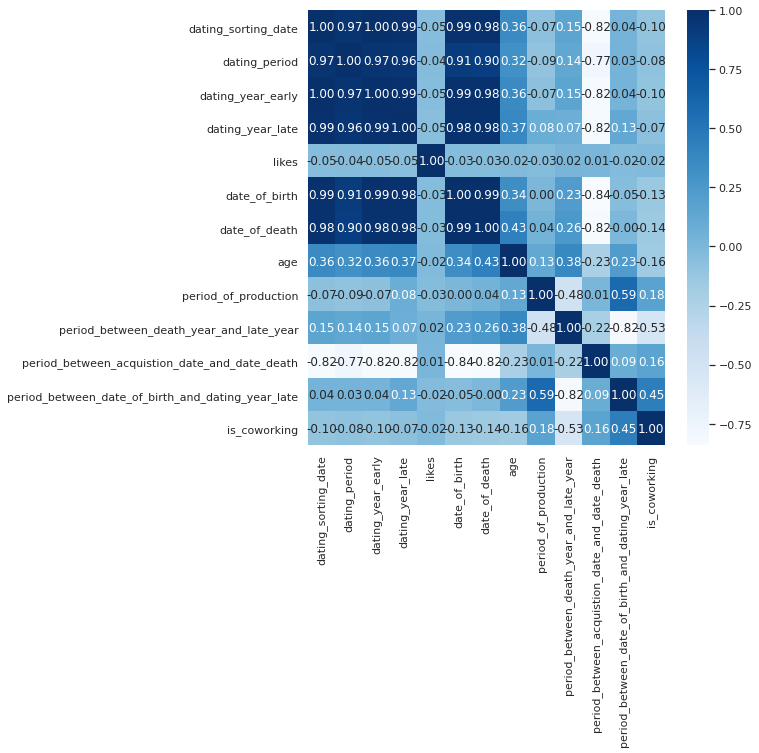

In [86]:
corr = train_df.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")

In [87]:
OBJECT_ID = "object_id"
def left_join(left, right, on=OBJECT_ID):
    if isinstance(left, pd.DataFrame):
        left = left[on]
    return pd.merge(left, right, on=on, how='left').drop(columns=[on])

In [88]:
os.chdir(CODE_PATH)
from util import AbstractBaseBlock
from feature_engine import *
class MaterialBlock(AbstractBaseBlock):
    def __init__(self, min_count=30):
        self.min_count = min_count

    def fit(self, input_df, y=None):
      material_df = read_csv('material')
      vc = material_df['name'].value_counts()
      # 出現回数30以上に絞る
      use_names = vc[vc >= self.min_count].index

      # isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
      idx = material_df['name'].isin(use_names)
      _use_df = material_df[idx].reset_index(drop=True)

      self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
      return self.transform(input_df)

    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'MaterialBlock_name=')


class TechiqueBlock(AbstractBaseBlock):
    def __init__(self, min_count=30):
        self.min_count = min_count

    def fit(self, input_df, y=None):
      techique_df = read_csv('technique')
      vc = technique_df['name'].value_counts()
      # 出現回数30以上に絞る
      use_names = vc[vc >= self.min_count].index

      # isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
      idx = technique_df['name'].isin(use_names)
      _use_df = technique_df[idx].reset_index(drop=True)

      self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
      return self.transform(input_df)

    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'TechniqueBlock_name=')

class CollectionBlock(AbstractBaseBlock):
    def __init__(self, min_count=30):
        self.min_count = min_count

    def fit(self, input_df, y=None):
      collection_df = read_csv('object_collection')
      vc = collection_df['name'].value_counts()
      # 出現回数30以上に絞る
      use_names = vc[vc >= self.min_count].index

      # isin で 30 回以上でてくるようなレコードに絞り込んでから corsstab を行なう
      idx = collection_df['name'].isin(use_names)
      _use_df = collection_df[idx].reset_index(drop=True)

      self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
      return self.transform(input_df)

    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'CollectionBlock_name=')


class GetLanguageLabel(AbstractBaseBlock):
  """
  言語判定するブロック
  """
  def __init__(self, cols):
    self.cols = cols

  def fit(self, input_df):
    return self.transform(input_df)

  def transform(self, input_df):
    out_df = pd.DataFrame()
    self.model = load_model("/content/drive/MyDrive/atmacup10/data/external/lid.176.bin")
    out_df[self.cols] = input_df[self.cols].fillna("").map(lambda x: self.model.predict(x.replace("\n", ""))[0][0])
    return out_df.add_prefix("lang_label_")

class GetCountString(AbstractBaseBlock):  
  """
  文字数を取得するブロック
  """
  def __init__(self, cols):
    self.cols = cols

  def transform(self, input_df):
    _input_df = input_df[self.cols].fillna("NaN")
    out_df = pd.DataFrame()
    out_df[self.cols] = input_df[self.cols].fillna("NaN").str.len()
    return out_df.add_prefix("count_string_")

In [91]:

from time import time
from tqdm import tqdm
from contextlib import contextmanager

def get_function(block,is_train):
    s = mapping ={
        True:'fit',
        False:'transform'
    }.get(is_train)
    return getattr(block,s)

def to_feature(input_df,remain_df,blocks,is_train=False):
    out_df = remain_df
    
    for block in tqdm(blocks,total=len(blocks)):
        func = get_function(block,is_train)
        
        with timer(prefix='create' + str(block) + ' '):
            _df = func(input_df)
        print(len(_df), len(input_df))
        assert len(_df) == len(input_df),func._name_
        out_df = pd.concat([out_df,_df],axis=1)
    return out_df

@contextmanager
def timer(logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None):
  if prefix: format_str = str(prefix) + format_str
  if suffix: format_str = format_str + str(suffix)
  start = time()
  yield
  d = time() - start
  out_str = format_str.format(d)
  if logger:
    logger.info(out_str)
  else:
    print(out_str)

In [111]:
add_feature_block = [
                     GetLanguageLabel("title"),
                     GetLanguageLabel("description"),
                     GetLanguageLabel("long_title"),
                     GetCountString("title"),
                     GetCountString("description"),
                     GetCountString("acquisition_credit_line"),
                     GetCountString("long_title"),
                     GetCountString("more_title"),
                     GetCountString("sub_title"),

]

train_feat_df = to_feature(train_df, train_df, add_feature_block, is_train=True)
test_feat_df = to_feature(test_df, test_df, add_feature_block, is_train=False)
print(train_df.shape, test_df.shape)

 11%|█         | 1/9 [00:00<00:04,  1.66it/s]

create<__main__.GetLanguageLabel object at 0x7f111cd56fd0> 0.594[s]
12026 12026


 22%|██▏       | 2/9 [00:01<00:04,  1.45it/s]

create<__main__.GetLanguageLabel object at 0x7f111cd4f050> 0.877[s]
12026 12026


 78%|███████▊  | 7/9 [00:02<00:00,  2.02it/s]

create<__main__.GetLanguageLabel object at 0x7f111cd4f090> 0.676[s]
12026 12026
create<__main__.GetCountString object at 0x7f111cd4f0d0> 0.011[s]
12026 12026
create<__main__.GetCountString object at 0x7f111cd4f110> 0.010[s]
12026 12026
create<__main__.GetCountString object at 0x7f111cd4f150> 0.009[s]
12026 12026
create<__main__.GetCountString object at 0x7f111cd4f190> 0.009[s]
12026 12026
create<__main__.GetCountString object at 0x7f111cd4f1d0> 0.012[s]
12026 12026
create<__main__.GetCountString object at 0x7f111cd4f210> 0.009[s]
12026 12026


 11%|█         | 1/9 [00:00<00:05,  1.56it/s]

create<__main__.GetLanguageLabel object at 0x7f111cd56fd0> 0.631[s]
12008 12008


 22%|██▏       | 2/9 [00:01<00:04,  1.43it/s]

create<__main__.GetLanguageLabel object at 0x7f111cd4f050> 0.822[s]
12008 12008


 67%|██████▋   | 6/9 [00:02<00:01,  1.96it/s]

create<__main__.GetLanguageLabel object at 0x7f111cd4f090> 0.718[s]
12008 12008
create<__main__.GetCountString object at 0x7f111cd4f0d0> 0.011[s]
12008 12008
create<__main__.GetCountString object at 0x7f111cd4f110> 0.012[s]
12008 12008
create<__main__.GetCountString object at 0x7f111cd4f150> 0.011[s]
12008 12008
create<__main__.GetCountString object at 0x7f111cd4f190> 0.010[s]
12008 12008
create<__main__.GetCountString object at 0x7f111cd4f1d0> 0.010[s]
12008 12008


100%|██████████| 9/9 [00:02<00:00,  3.70it/s]

create<__main__.GetCountString object at 0x7f111cd4f210> 0.010[s]
12008 12008
(12026, 31) (12008, 30)


In [112]:
train_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12026 entries, 0 to 12025
Data columns (total 40 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   object_id                                          12026 non-null  object 
 1   art_series_id                                      12026 non-null  object 
 2   title                                              12026 non-null  object 
 3   description                                        8506 non-null   object 
 4   long_title                                         12026 non-null  object 
 5   principal_maker                                    12026 non-null  object 
 6   principal_or_first_maker                           12025 non-null  object 
 7   sub_title                                          11992 non-null  object 
 8   copyright_holder                                   713 non-null    object 
 9   more_t

In [113]:
agg_columns = ["dating_period", "count_string_title", "count_string_description", "count_string_sub_title",
                 "count_string_more_title", "count_string_long_title", "count_string_acquisition_credit_line", 
                 "age", "period_of_production", "period_between_death_year_and_late_year", 
                 "period_between_acquistion_date_and_date_death", "period_between_date_of_birth_and_dating_year_late"
                  ]

process_blocks = [
                 LabelEncodingBlock("acquisition_method"),
                 LabelEncodingBlock("principal_maker"),
                 LabelEncodingBlock("lang_label_title"),
                 LabelEncodingBlock("lang_label_description"),
                 LabelEncodingBlock("lang_label_long_title"),
                 LabelEncodingBlock("title"),
                 LabelEncodingBlock("description"),
                 CountEncodingBlock("acquisition_method"),
                 CountEncodingBlock("principal_maker"),
                 CountEncodingBlock("lang_label_title"),
                 CountEncodingBlock("lang_label_description"),
                 CountEncodingBlock("title"),
                 CountEncodingBlock("description"),
                 MaterialBlock(min_count=19),
                 CollectionBlock(min_count=3),
                 AggregationBlock(group_key="acquisition_method",
                                  group_values=agg_columns,
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="principal_maker",
                                  group_values=agg_columns,
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="lang_label_title",
                                  group_values=agg_columns,
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="lang_label_description",
                                  group_values=agg_columns,
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="lang_label_long_title",
                                  group_values=agg_columns,
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 
                 AggregationBlock(group_key="title",
                                  group_values=agg_columns,
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="dating_period",
                                  group_values=["count_string_title", "count_string_description", "count_string_sub_title",
                 "count_string_more_title", "count_string_long_title", "count_string_acquisition_credit_line", 
                 "age", "period_of_production", "period_between_death_year_and_late_year", 
                 "period_between_acquistion_date_and_date_death", "period_between_date_of_birth_and_dating_year_late"
                  ],
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                  Word2VecBlock(model_size),

                 ]
drop_columns = ["description", "title", "principal_maker", "principal_or_first_maker", "long_title", "object_id", "art_series_id",
                  "sub_title", "copyright_holder", "more_title", "acquisition_credit_line", "dating_presenting_date",
                  "dating_sorting_date", "acquisition_date", "acquisition_method", "lang_label_title", "lang_label_description", "lang_label_long_title",
                  "dating_year_late", "dating_year_early", "nationality", "place_of_death", "place_of_birth", "name"]

train_feat_df = to_feature(train_feat_df,train_feat_df.drop(columns=drop_columns, axis=1),process_blocks, is_train=True)

test_feat_df = to_feature(test_feat_df,test_feat_df.drop(columns=drop_columns, axis=1),process_blocks,is_train=False)

  0%|          | 0/23 [00:00<?, ?it/s]

create<feature_engine.LabelEncodingBlock object at 0x7f11390cb850> 0.013[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f11390cb8d0> 0.013[s]
12026 12026


 26%|██▌       | 6/23 [00:00<00:00, 51.25it/s]

create<feature_engine.LabelEncodingBlock object at 0x7f11390cb910> 0.024[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f11390cb950> 0.012[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f11390cb990> 0.011[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f11390cb9d0> 0.019[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f11390cba10> 0.021[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f11390cba50> 0.009[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f11390cba90> 0.010[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f11390cbad0> 0.009[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f11390cbb10> 0.009[s]
12026 12026


 52%|█████▏    | 12/23 [00:00<00:00, 52.49it/s]

create<feature_engine.CountEncodingBlock object at 0x7f11390cbb50> 0.015[s]
12026 12026
create<feature_engine.CountEncodingBlock object at 0x7f11390cbb90> 0.020[s]
12026 12026


 65%|██████▌   | 15/23 [00:00<00:00, 15.76it/s]

create<__main__.MaterialBlock object at 0x7f11390cbbd0> 0.317[s]
12026 12026
create<__main__.CollectionBlock object at 0x7f11390cbc10> 0.139[s]
12026 12026
create<feature_engine.AggregationBlock object at 0x7f11390cbc50> 1.418[s]
12026 12026


 74%|███████▍  | 17/23 [00:44<00:39,  6.62s/it]

create<feature_engine.AggregationBlock object at 0x7f11390cbc90> 42.389[s]
12026 12026


 78%|███████▊  | 18/23 [00:46<00:25,  5.17s/it]

create<feature_engine.AggregationBlock object at 0x7f11390cbcd0> 1.766[s]
12026 12026


 83%|████████▎ | 19/23 [00:47<00:16,  4.02s/it]

create<feature_engine.AggregationBlock object at 0x7f11390cbd10> 1.298[s]
12026 12026


 87%|████████▋ | 20/23 [00:49<00:09,  3.27s/it]

create<feature_engine.AggregationBlock object at 0x7f11390cbd50> 1.449[s]
12026 12026


 91%|█████████▏| 21/23 [03:55<01:56, 58.08s/it]

create<feature_engine.AggregationBlock object at 0x7f11390cbd90> 185.924[s]
12026 12026


 96%|█████████▌| 22/23 [03:56<00:41, 41.00s/it]

create<feature_engine.AggregationBlock object at 0x7f11390cbdd0> 1.087[s]
12026 12026
run



100%|██████████| 23586/23586 [00:00<00:00, 28090.07it/s]

100%|██████████| 14160/14160 [00:00<00:00, 28504.79it/s]

100%|██████████| 17329/17329 [00:00<00:00, 21080.74it/s]

100%|██████████| 23597/23597 [00:01<00:00, 22890.09it/s]

100%|██████████| 23950/23950 [00:00<00:00, 32840.08it/s]

100%|██████████| 21646/21646 [00:00<00:00, 27262.11it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

create<__main__.Word2VecBlock object at 0x7f11390cbe10> 33.250[s]
12026 12026
create<feature_engine.LabelEncodingBlock object at 0x7f11390cb850> 0.011[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f11390cb8d0> 0.016[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f11390cb910> 0.010[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f11390cb950> 0.009[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f11390cb990> 0.010[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f11390cb9d0> 0.013[s]
12008 12008
create<feature_engine.LabelEncodingBlock object at 0x7f11390cba10> 0.012[s]
12008 12008


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

 57%|█████▋    | 13/23 [00:00<00:00, 59.66it/s]

create<feature_engine.CountEncodingBlock object at 0x7f11390cba50> 0.009[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7f11390cba90> 0.013[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7f11390cbad0> 0.009[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7f11390cbb10> 0.009[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7f11390cbb50> 0.014[s]
12008 12008
create<feature_engine.CountEncodingBlock object at 0x7f11390cbb90> 0.018[s]
12008 12008
create<__main__.MaterialBlock object at 0x7f11390cbbd0> 0.021[s]
12008 12008
create<__main__.CollectionBlock object at 0x7f11390cbc10> 0.014[s]
12008 12008


 70%|██████▉   | 16/23 [00:01<00:00,  7.09it/s]

create<feature_engine.AggregationBlock object at 0x7f11390cbc50> 1.232[s]
12008 12008


 74%|███████▍  | 17/23 [00:43<01:16, 12.67s/it]

create<feature_engine.AggregationBlock object at 0x7f11390cbc90> 41.885[s]
12008 12008


 78%|███████▊  | 18/23 [00:45<00:47,  9.40s/it]

create<feature_engine.AggregationBlock object at 0x7f11390cbcd0> 1.758[s]
12008 12008


 83%|████████▎ | 19/23 [00:46<00:27,  6.95s/it]

create<feature_engine.AggregationBlock object at 0x7f11390cbd10> 1.182[s]
12008 12008


 87%|████████▋ | 20/23 [00:47<00:15,  5.33s/it]

create<feature_engine.AggregationBlock object at 0x7f11390cbd50> 1.518[s]
12008 12008


 91%|█████████▏| 21/23 [03:56<02:00, 60.29s/it]

create<feature_engine.AggregationBlock object at 0x7f11390cbd90> 188.447[s]
12008 12008


100%|██████████| 23/23 [03:57<00:00, 10.34s/it]

create<feature_engine.AggregationBlock object at 0x7f11390cbdd0> 1.167[s]
12008 12008
create<__main__.Word2VecBlock object at 0x7f11390cbe10> 0.038[s]
12008 12008


In [114]:
y = np.log1p(train_df["likes"])
train_feat_df = train_feat_df.drop(columns=["likes"], axis=1)

In [115]:
from gensim.models import word2vec

model_size = {
    "material": 20,
    "technique": 8,
    "collection": 3,
    "material_collection": 20,
    "material_technique": 20,
    "collection_technique": 10,
    "material_collection_technique": 25
}


class Word2VecBlock(AbstractBaseBlock):
  def __init__(self, model_size:tuple):
    self.model_size = model_size

  def fit(self, input_df, y=None):
    material_df = read_csv("material")
    technique_df = read_csv("technique")
    collection = read_csv("object_collection")

    mat_col = pd.concat([material_df, collection], axis=0).reset_index(drop=True)
    mat_tec = pd.concat([material_df, technique_df], axis=0).reset_index(drop=True)
    col_tec = pd.concat([collection, technique_df], axis=0).reset_index(drop=True)
    mat_col_tec = pd.concat([material_df, collection, technique_df], axis=0).reset_index(drop=True)

    w2v_dfs = []
    for df, df_name in zip(
            [
                material_df, collection, technique_df,
                mat_col, mat_tec, col_tec, mat_col_tec
            ], [
                "material", "collection", "technique",
                "material_collection",
                "material_technique",
                "collection_technique",
                "material_collection_technique"
            ]):
        df_group = df.groupby("object_id")["name"].apply(list).reset_index()
        # Word2Vecの学習
        w2v_model = word2vec.Word2Vec(df_group["name"].values.tolist(),
                                      size=model_size[df_name],
                                      min_count=1,
                                      window=1,
                                      iter=100)

        # 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって文章ベクトルにする
        sentence_vectors = df_group["name"].progress_apply(
            lambda x: np.mean([w2v_model.wv[e] for e in x], axis=0))
        sentence_vectors = np.vstack([x for x in sentence_vectors])
        sentence_vector_df = pd.DataFrame(sentence_vectors,
                                          columns=[f"{df_name}_w2v_{i}"
                                                  for i in range(model_size[df_name])])
        sentence_vector_df.index = df_group["object_id"]
        w2v_dfs.append(sentence_vector_df)

    tmp_2 = pd.merge(w2v_dfs[0], w2v_dfs[1], on='object_id', how="left")
    tmp_3 = pd.merge(w2v_dfs[2], w2v_dfs[3], on='object_id', how="left")
    tmp_4 = pd.merge(w2v_dfs[4], w2v_dfs[5], on='object_id', how="left")
    tmp_5 = pd.merge(tmp_2, w2v_dfs[6], on="object_id", how="left")
    tmp_2 = pd.merge(tmp_3, tmp_4, on="object_id", how="left")
    self._df = pd.merge(tmp_5, tmp_2, on="object_id", how="left")

    return self.transform(input_df)
      
  def transform(self, input_df):
    out_df = pd.DataFrame()
    out_df = left_join(input_df, self._df)
    return out_df

In [116]:
train_feat_df.shape, test_feat_df.shape

((12026, 660), (12008, 660))

In [117]:

from sklearn.metrics import mean_squared_error
import lightgbm as lgbm
def fit_lgbm(X,
             y,
             cv, 
             params: dict=None,
             verbose: int=50):
    
    metric_func = mean_squared_error
    
    if params is None:
        params = {}
        
    models = []
    
    oof_pred = np.zeros_like(y ,dtype=np.float)
    
    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, x_valid = X[idx_train], X[idx_valid]
        y_train, y_valid = y[idx_train], y[idx_valid]
        
        clf = lgbm.LGBMRegressor(**params)
        
        with timer(prefix="fit fold={}".format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],
                    early_stopping_rounds=verbose,
                    verbose=verbose)
            
        pred_i = clf.predict(x_valid)
        
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        
        print(f'K Fold {i} RMSLE: {metric_func(y_valid, pred_i) ** .5:.4f}')
        
    score = metric_func(y, oof_pred) ** .5
    print('FINIHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [118]:
params = {
    "objective": "rmse",
    "max_depth": 5,
    "n_estimators": 100000,
    "learning_rate": 0.01,
    "colsample_bytree": .5,
    "importance_type": "gain",
}

from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y))

oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)

Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.09527
[1000]	valid_0's rmse: 1.08338
[1500]	valid_0's rmse: 1.07633
[2000]	valid_0's rmse: 1.07005
[2500]	valid_0's rmse: 1.06739
[3000]	valid_0's rmse: 1.06604
[3500]	valid_0's rmse: 1.0655
[4000]	valid_0's rmse: 1.06606
Early stopping, best iteration is:
[3518]	valid_0's rmse: 1.06542
fit fold=158.288[s]
K Fold 0 RMSLE: 1.0654
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.09018
[1000]	valid_0's rmse: 1.07307
[1500]	valid_0's rmse: 1.06216
[2000]	valid_0's rmse: 1.0555
[2500]	valid_0's rmse: 1.05168
[3000]	valid_0's rmse: 1.0497
[3500]	valid_0's rmse: 1.04852
[4000]	valid_0's rmse: 1.04803
[4500]	valid_0's rmse: 1.0474
[5000]	valid_0's rmse: 1.04711
Early stopping, best iteration is:
[4735]	valid_0's rmse: 1.04684
fit fold=273.777[s]
K Fold 1 RMSLE: 1.0468
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.07958
[1000]	vali

In [133]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[3:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    return fig, ax

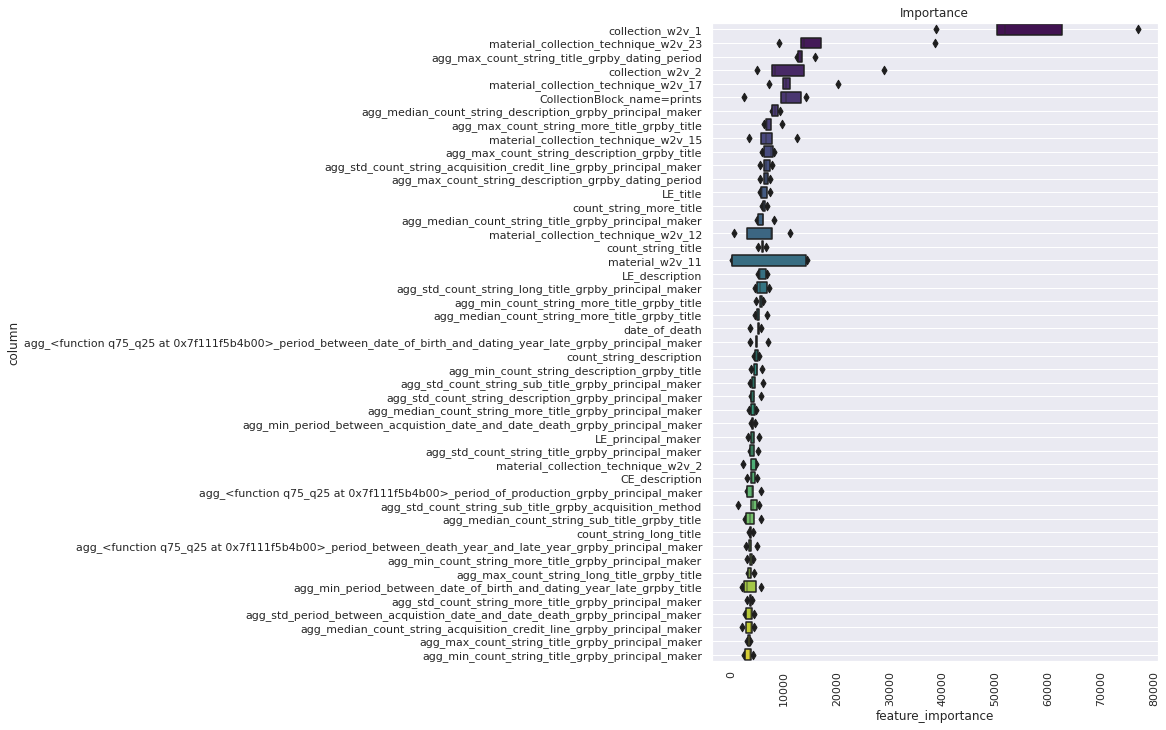

In [134]:
fig, _ = visualize_importance(models, feat_train_df=train_feat_df)

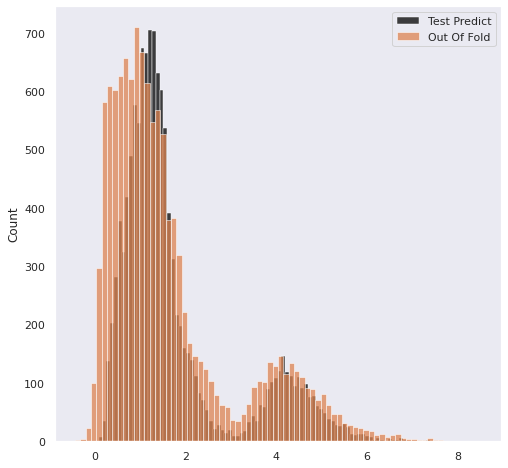

In [121]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred


pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = revert_to_real(pred)
sub_df = pd.DataFrame({ 'likes': pred })

fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()

In [122]:
sub_df.to_csv(os.path.join(OUTPUT_PAHT, 'exp6.csv'), index=False)

In [140]:
train_feat_df.corr().sample(40)

,dating_period,date_of_birth,date_of_death,age,period_of_production,period_between_death_year_and_late_year,period_between_acquistion_date_and_date_death,period_between_date_of_birth_and_dating_year_late,is_coworking,count_string_title,count_string_description,count_string_acquisition_credit_line,count_string_long_title,count_string_more_title,count_string_sub_title,LE_acquisition_method,LE_principal_maker,LE_lang_label_title,LE_lang_label_description,LE_lang_label_long_title,LE_title,LE_description,CE_acquisition_method,CE_principal_maker,CE_lang_label_title,CE_lang_label_description,CE_title,CE_description,MaterialBlock_name=RC paper,MaterialBlock_name=baryta paper,MaterialBlock_name=canvas,MaterialBlock_name=cardboard,MaterialBlock_name=celluloid (cellulosic),MaterialBlock_name=copper (metal),MaterialBlock_name=glass,MaterialBlock_name=ink,MaterialBlock_name=leather,MaterialBlock_name=linen (material),MaterialBlock_name=metal,MaterialBlock_name=oil paint (paint),...,material_collection_w2v_10,material_collection_w2v_11,material_collection_w2v_12,material_collection_w2v_13,material_collection_w2v_14,material_collection_w2v_15,material_collection_w2v_16,material_collection_w2v_17,material_collection_w2v_18,material_collection_w2v_19,material_technique_w2v_0,material_technique_w2v_1,material_technique_w2v_2,material_technique_w2v_3,material_technique_w2v_4,material_technique_w2v_5,material_technique_w2v_6,material_technique_w2v_7,material_technique_w2v_8,material_technique_w2v_9,material_technique_w2v_10,material_technique_w2v_11,material_technique_w2v_12,material_technique_w2v_13,material_technique_w2v_14,material_technique_w2v_15,material_technique_w2v_16,material_technique_w2v_17,material_technique_w2v_18,material_technique_w2v_19,collection_technique_w2v_0,collection_technique_w2v_1,collection_technique_w2v_2,collection_technique_w2v_3,collection_technique_w2v_4,collection_technique_w2v_5,collection_technique_w2v_6,collection_technique_w2v_7,collection_technique_w2v_8,collection_technique_w2v_9
agg_<function max_min at 0x7f112de17830>_count_string_description_grpby_lang_label_description,-0.352443,-0.419813,-0.405949,-0.153419,-0.077221,0.002645,0.269272,-0.080529,0.053131,-0.102901,0.610821,0.081624,-0.113694,0.053671,0.239587,-0.156633,0.013777,-0.041124,0.906757,-0.091495,0.017811,0.596153,-0.063076,-0.020297,-0.213492,0.995892,-0.157553,-0.987338,-0.055794,-0.144517,0.198830,-0.337859,-0.074015,-0.067763,-0.218580,0.017044,-0.111214,-0.030560,-0.062886,0.283863,...,0.078544,0.049278,0.109294,0.278421,-0.122238,-0.289428,0.232254,-0.246716,-0.075879,-0.380065,-0.192331,0.195845,0.179081,-0.299453,0.197044,0.376511,-0.163395,-0.310931,-0.315946,0.363911,0.103573,0.141687,-0.391812,0.300026,-0.063978,0.134028,0.329062,-0.389814,-0.388301,-0.079786,-0.394568,0.351457,-0.414742,0.324124,0.371431,0.394014,-0.412372,0.293784,0.074659,0.368517
agg_median_age_grpby_lang_label_long_title,-0.082741,-0.051825,-0.041648,0.023476,0.023010,0.002887,0.043932,0.009744,0.006934,-0.092787,0.074894,0.114566,-0.055596,-0.130592,0.267154,-0.031828,0.123807,-0.018561,0.098231,-0.225703,0.037184,0.122080,-0.069532,-0.026529,-0.469657,0.092414,-0.042098,-0.103902,-0.004389,-0.029274,0.271912,-0.037327,-0.017288,0.033400,-0.042240,0.000227,-0.023720,0.010481,-0.020802,0.421179,...,-0.063622,-0.022367,-0.008836,-0.071886,0.015601,0.051277,-0.081012,0.014954,0.046533,0.081017,0.041902,-0.084389,-0.075064,0.076584,-0.040448,-0.097407,0.042599,0.099843,0.091182,-0.065660,-0.008089,-0.081835,0.126301,-0.090098,0.020418,-0.087196,-0.100694,0.044550,0.079566,0.124257,0.113847,-0.090356,0.102057,-0.035050,-0.067499,-0.113193,0.035146,-0.037557,0.035796,-0.073630
agg_median_count_string_sub_title_grpby_title,-0.106875,-0.050134,-0.046658,-0.028023,0.043879,-0.037076,-0.016441,0.023938,0.004805,-0.056539,0.160250,0.205181,-0.048207,-0.095696,0.974866,-0.104515,0.236460,-0.119450,0.223897,-0.229953,0.020461,0.236442,-0.188041,-0.088925,-0.404430,0.242755,